In [ ]:
import gymnasium as gym 
from gymnasium import spaces 
import numpy as np 
import math 
import matplotlib.pyplot as plt

class TwoD_Robot(gym.Env): 
    def __init__(self):

        self.L1 = 42.5 
        self.L2 = 39.22 
        self.L3 = 9.97

        goal_init = [0,30,np.pi] 
        self.goal = np.array(goal_init)
        
        # Action space: [delta_Theta1, delta_Theta2, delta_Theta3]
        self.action_space = spaces.Box(low= -0.1, high =0.1, shape = (3,))
       
        # endeffektor pose, joint angles, goal 
        self.observation_space = spaces.Dict(
            {
                "pose": spaces.Box(
                        low = np.array([-100,-100,-2*np.pi]),
                        high =np.array([100,100,2*np.pi]), 
                        dtype = float
                    ), 
                "motors": spaces.Box(
                        low = np.array([-np.pi, -np.pi, -np.pi]),
                        high =np.array([ np.pi, np.pi, np.pi]),
                        dtype = float
                    ),
                 "goal": spaces.Box(
                        low = np.array([-100,-100,np.pi]),
                        high =np.array([100,100,np.pi]), 
                        dtype = float
                    ),
                "distance": spaces.Box(
                        low = np.array([0,0]),
                        high = np.array([200, 2*np.pi]),
                        dtype = float
                    )    
            } 
        )

        #initial robot pose  
        self.theta = np.array([0.0,0.0,0.0])
        self.ee_pose = self.forward_kinematics(self.theta)
    
    # returns ee_pose from given motorangles 
    def forward_kinematics(self,theta):
        """compute Endeffector Pose and returns x,y and theta (angles). zero pose is a vertical line"""
        x = (self.L1 * np.sin(theta[0]) +
            self.L2 * np.sin(theta[0] + theta[1]) +
            self.L3 * np.sin(theta[0] + theta[1] + theta[2]))
        y = (self.L1 * np.cos(theta[0]) +
            self.L2 * np.cos(theta[0] + theta[1]) +
            self.L3 * np.cos(theta[0] + theta[1] + theta[2]))
        theta_E = theta[0] + theta[1] + theta[2]
        return np.array([x,y,theta_E])
         
    # retruns dict with observation ee_pose, goal, motorangles, distance to goal 
    def _get_obs(self):
        self.ee_pose = self.forward_kinematics(self.theta)
        dist_to_goal = np.array(np.linalg.norm(self.ee_pose[:2] - self.goal[:2]))
        angle_distance = np.abs(np.abs(self.ee_pose[2] - self.goal[2]))
        dist_total = np.array([dist_to_goal, angle_distance])
    
        observation = {
            "pose": self.ee_pose,
            "motors": self.theta,
            "goal": self.goal, 
            "distance": dist_total
        }
       
        
        return observation
    
    #return empty dict
    def _get_info(self):
        info= {    
        } 
        return info   
    
    #return reward and if goal     
    def _get_reward(self):
        distance_to_goal = np.linalg.norm(self.ee_pose[:2] - self.goal[:2])
        angle_distance = np.abs(self.ee_pose[2] - self.goal[2])
        r_d = - distance_to_goal* 10
        r_a = - angle_distance / np.pi 

        if (distance_to_goal < 2 and
            angle_distance < np.pi/8):
            r_done = 500 
            done = True
        else: 
            done = False
            r_done = 0 

        reward = r_d + r_a + r_done 
                
        return reward, done       
     
    # set the robot to random state and defines new goal, returns new observation   
    def reset(self, seed = None, options = None):
        #returns new random state and emptyinfo 
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
        self.np_random, _ = gym.utils.seeding.np_random(seed)
        self.theta = np.random.uniform(-np.pi, np.pi, size = 3)
        self.ee_pose = self.forward_kinematics(self.theta)
        
        #set new goal 
        rad = np.sqrt(np.random.uniform(0,1))* 60
        angle = np.random.uniform(-np.pi,np.pi)
        x = rad * np.cos(angle)
        y = rad * np.sin(angle)
        theta_e = angle 
        
        self.goal = np.array([x,y,theta_e])

        observation = self._get_obs()
        info = self._get_info()
        return observation, info 
    
    
    #returns observation, reward, done = bool, truncated = False, info = empty  
    def step(self,action):
        # perform action and oberve 
        self.theta += action
        self.theta = np.clip(self.theta, -np.pi, np.pi)  # Keep angles in range
        self.ee_pose = self.forward_kinematics(self.theta)
        
        observation = self._get_obs()
        
        reward, done = self._get_reward()
        truncated = False
        info = self._get_info()
        return observation, reward, done, truncated, info 
    
    
    def render(self): 
        goal = self.goal
        angles = self.theta
        links = np.array([self.L1,self.L2,self.L3])
        #end of each Link
        Ey1 = math.cos(angles[0])*links[0]
        Ex1 = math.sin(angles[0])*links[0]
        Ey2 = math.cos(angles[0]+angles[1])*links[1] + Ey1
        Ex2 = math.sin(angles[0]+angles[1])*links[1] + Ex1
        Ey3 = math.cos(angles[0]+angles[1]+ angles[2]) * links[2] + Ey2
        Ex3 = math.sin(angles[0]+angles[1]+angles[2]) * links[2] + Ex2 

        joints = np.array([[0,Ex1,Ex2,Ex3],[0,Ey1,Ey2,Ey3]])
        plt.figure
        plt.plot(joints[0],joints[1], '-o')
        print("goal:",self.goal)
        #plt.plot(goal,'x', markersize = 8 )



        


# Test Environment 

In [33]:
from stable_baselines3.common.env_checker import check_env

env = TwoD_Robot()
check_env(env)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1062 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 838          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0007255585 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | -0.000161    |
|    learning_rate        | 0.0003       |
|    loss                 | 4.95e+07     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00152     |
|    st

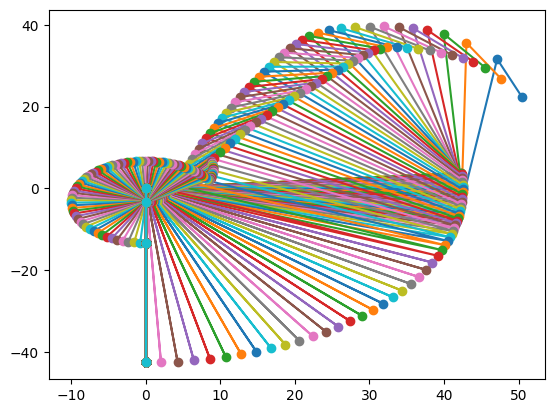

In [51]:
from stable_baselines3 import PPO                                                       
                                                                                           
env = TwoD_Robot()
                                                                                  
model = PPO(policy = "MultiInputPolicy",env =  env, verbose=1)                                 
model.learn(total_timesteps=25000)                                                      
                                                                                        
model.save("ppo_cartpole")  # saving the model to ppo_cartpole.zip                      
model = PPO.load("ppo_cartpole")  # loading the model from ppo_cartpole.zip             
                                                                                        
obs, info = env.reset()                                                                       
for i in range(5000):                                                                   
    action, _state = model.predict(obs, deterministic=True)                             
    obs, reward, done,truncated, info = env.step(action)                                          
    env.render()                                                                        
    if done:                                                                            
      obs = env.reset()     